In [4]:

import pandas as pd
from scipy import sparse 
from typing import Optional
import numpy as np
import random as rnd
from sklearn.preprocessing import MinMaxScaler
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# week 1: member 2

data = pd.read_excel(r"C:\Users\Admin\OneDrive\Documents\Economics analysis\Brazillian_2011_datamining\data\raw\sales_and_customer_insights_dirty.xlsx")
print(data.head())



# View basic info
print("\n Dataset Info:")
print(data.info())

print("\n First 5 Rows:")
print(data.head())

print("\n Missing Values Count:")
print(data.isnull().sum())

print("\n Duplicate Rows:", data.duplicated().sum())

print("\n Summary Statistics:")
print(data.describe(include='all'))




# --- Step 3: Check for negative or zero quantities and prices ---
negative_qty = data[data['Quantity'] <= 0]
negative_price = data[data['UnitPrice'] <= 0]

print(f"\n Rows with non-positive quantities: {len(negative_qty)}")
print(f" Rows with non-positive unit prices: {len(negative_price)}")

# --- Step 4: Check country name inconsistencies ---
print("\n Unique countries:\n", data['Country'].unique())

# --- Step 5: Quick check for outliers using describe() ---
print("\n Summary statistics for numeric columns:\n", data.describe())


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER       6.0   
1    536365     71053                  WHITE METAL LANTERN       6.0   
2       NaN    84406B       CREAM CUPID HEARTS COAT HANGER       8.0   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE       6.0   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.       6.0   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0             NaN  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  

 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547328 entries, 0 to 547327
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------  

In [10]:

# week 2

# member 1
# --- WEEK 2: Build ETL Pipeline, Handle Missing Data (Member 1 Task) ---

def build_etl_pipeline(file_path: str) -> pd.DataFrame:
    """
    Loads data, cleans column names, converts types, and handles missing values.
    """

    print(f"\n--- Starting ETL Pipeline: Loading {file_path} ---")

    # 1. Extract
    try:
        df = pd.read_excel(file_path)
    except FileNotFoundError:
        print(f"Error: file not found: {file_path}")
        return None
    except Exception as e:
        print(f"Error reading file: {e}")
        return None

    # Clean column names
    df.columns = df.columns.str.strip()
    print(f"Initial shape: {df.shape}")

    # Convert types
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

    # Remove invalid rows
    invalid_count = df[(df['Quantity'] <= 0) | (df['UnitPrice'] <= 0)].shape[0]
    df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

    print(f"Removed {invalid_count} invalid transactions.")
    print(f"Final shape: {df.shape}")

    return df

df = build_etl_pipeline(r"C:\Users\Admin\OneDrive\Documents\Economics analysis\Brazillian_2011_datamining\data\raw\sales_and_customer_insights_dirty.xlsx")
if df is None or not isinstance(df, pd.DataFrame):
    raise RuntimeError("ETL pipeline failed to produce DataFrame — check earlier errors/logs")


# member 2

data= df.copy()
# 1. Remove Duplicate Records

duplicates_before = df.duplicated().sum()
data = data.drop_duplicates()
duplicates_after = data.duplicated().sum()

print(f"Duplicates removed: {duplicates_before - duplicates_after}")


# 2. Handle Missing Values


# a) Fill missing Description with "Unknown Product"
data['Description'] = data['Description'].dropna()

# b) Country missing → Fill as "Unknown"
data['Country'] = data['Country'].fillna("Unknown")

# c) InvoiceDate missing → Remove (these are unusable)
data = data.dropna(subset=['InvoiceDate'])

# d) StockCode & InvoiceNo (critical identifiers) → remove missing
data = data.dropna(subset=['InvoiceNo', 'StockCode'])

# e) CustomerID → Keep but mark missing as -1 for analysis
data['CustomerID'] = data['CustomerID'].fillna(-1)


# 3. Fix Invalid Negative Values

# Negative quantity means returns → keep but tag
data['IsReturn'] = data['Quantity'] < 0



# 4. Standardize Country Names

country_replacements = {
    "RSA": "South Africa",
    "EIRE": "Ireland",
    "European Community": "Europe",
    "Unspecified": "Unknown"
}
data['Country'] = data['Country'].replace(country_replacements)


# 5. Create Calculated Fields (For Week 4 Mining)


# Total price per transaction
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

# Extract date components
data['Year'] = data['InvoiceDate'].dt.year
data['Month'] = data['InvoiceDate'].dt.month
data['Day'] = data['InvoiceDate'].dt.day


# 6. Save Cleaned Dataset

cleaned_path = "C:/Users/Admin/OneDrive/Documents/Economics analysis/Brazillian_2011_datamining/data/raw/cleaned_data.csv"
data.to_csv(cleaned_path, index=False)
print("\nCLEANING COMPLETE. File saved to:")
print(cleaned_path)


#member 3

# 1. Detect Outliers Using IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Detect outliers in Quantity
quantity_outliers, q_low, q_high = detect_outliers_iqr(data, 'Quantity')

# Detect outliers in UnitPrice
price_outliers, p_low, p_high = detect_outliers_iqr(data, 'UnitPrice')

print("=== Quantity Outliers ===")
print(quantity_outliers.head())
print("\nQuantity Lower Bound:", q_low)
print("Quantity Upper Bound:", q_high)

print("\n=== UnitPrice Outliers ===")
print(price_outliers.head())
print("\nUnitPrice Lower Bound:", p_low)
print("UnitPrice Upper Bound:", p_high)

# 2. Suggested Handling Strategies (code-ready)


# Remove negative quantities (invalid)
df_clean = data[data['Quantity'] >= 0]

# Option 1: Remove extremely high outliers
df_clean = df_clean[(df_clean['Quantity'] <= q_high)]
df_clean = df_clean[(df_clean['UnitPrice'] <= p_high)]

# Option 2: Cap values (Winsorization)
df_capped = df_clean.copy()
df_capped['Quantity'] = df_capped['Quantity'].clip(lower=q_low, upper=q_high)
df_capped['UnitPrice'] = df_capped['UnitPrice'].clip(lower=p_low, upper=p_high)

# Remove zero or negative prices
df_no_zero_price = data[data['UnitPrice'] > 0]

print("\nCleaning Completed. DataFrames Created:")
print("- df_no_quantity_outliers: removed extreme quantity outliers")
print("- df_capped: capped extreme values")
print("- df_no_zero_price: removed zero/negative prices")


# member 4
# --- Week 2: Preparation of data for mining (Scaling & Monthly Encoding) ---

def encode_monthly_transactions(df_input: pd.DataFrame, base_path: str):
    """
    Scales features, then splits the data by month, performs one-hot encoding
    for each month, and saves the encoded sparse matrix to separate CSV files.
    """
    print("\n--- Starting Monthly One-Hot Encoding for Apriori Analysis ---")
    
    # 1. Scaling (Performed once on the clean, full data)
    df_scaled = df_input.copy()

    scaler_Q = MinMaxScaler()
    scaler_UP = MinMaxScaler()
    df_scaled['scaled_Q'] = scaler_Q.fit_transform(df_scaled[['Quantity']])
    df_scaled['scaled_UP'] = scaler_UP.fit_transform(df_scaled[['UnitPrice']])
    
    print(f'Max Quantity (Cleaned): {df_scaled["Quantity"].max()}')
    print(f'Min Unit Price (Cleaned): {df_scaled["UnitPrice"].min()}')

    # 2. Iterate through each month and encode separately
    months = sorted(df_scaled['Month'].unique())
    
    for month_num in months:
        month_data = df_scaled[df_scaled['Month'] == month_num].copy()
        month_name = datetime(2023, month_num, 1).strftime('%B')
        
        print(f"\nProcessing {month_name} (Month {month_num}) with {month_data.shape[0]} transactions...")
        
        # Build transactions: list of lists (one transaction per invoice)
        transactions = month_data.groupby('InvoiceNo')['Description'] \
                                .apply(lambda items: items.dropna().astype(str).unique().tolist()) \
                                .tolist()

        if not transactions:
            print(f"Skipping {month_name}: No transactions found after grouping.")
            continue
            
        te = TransactionEncoder()
        te_data = te.fit(transactions).transform(transactions)

        # Convert safely and keep memory-efficient path for sparse matrices
        if sparse.issparse(te_data):
            # Option A: keep sparse and build a sparse-aware DataFrame
            encoded_products = pd.DataFrame.sparse.from_spmatrix(te_data, columns=list(te.columns_))
        else:
            te_array = np.asarray(te_data)
            encoded_products = pd.DataFrame(te_array, columns=list(te.columns_))

        # Ensure ints
        encoded_products = encoded_products.astype(int)

        # Save encoded_products
        # File name now includes the month for clarity
        encoded_products_path = f"{base_path}\\encoded_products_Month_{month_num:02d}.csv"
        encoded_products.to_csv(encoded_products_path, index=True)
        print(f"-> ENCODING COMPLETE for {month_name}. Saved {encoded_products.shape[0]} transactions to: {encoded_products_path}")

# Execute the monthly encoding
base_path = r"C:\Users\Admin\OneDrive\Documents\Economics analysis\Brazillian_2011_datamining\data\raw"
encode_monthly_transactions(df_clean, base_path)


--- Starting ETL Pipeline: Loading C:\Users\Admin\OneDrive\Documents\Economics analysis\Brazillian_2011_datamining\data\raw\sales_and_customer_insights_dirty.xlsx ---
Initial shape: (547328, 8)
Removed 11699 invalid transactions.
Final shape: (514256, 8)
Duplicates removed: 8065

CLEANING COMPLETE. File saved to:
C:/Users/Admin/OneDrive/Documents/Economics analysis/Brazillian_2011_datamining/data/raw/cleaned_data.csv
=== Quantity Outliers ===
   InvoiceNo StockCode                        Description  Quantity  \
9     536367     84879      ASSORTED COLOUR BIRD ORNAMENT     320.0   
31    536370     10002                                NaN      48.0   
44    536370     22492            MINI PAINT SET VINTAGE      360.0   
46    536371     22086    PAPER CHAIN KIT 50'S CHRISTMAS       80.0   
58    536373     82486  WOOD S/3 CABINET ANT WHITE FINISH      40.0   

           InvoiceDate  UnitPrice  CustomerID         Country  IsReturn  \
9  2010-12-01 00:00:00       1.69     13047.0  Uni

['United Kingdom' 'Unknown' 'France' 'Australia' 'Germany' 'Norway'
 'Ireland' 'Switzerland' 'Poland' 'Portugal' 'Italy' 'Belgium' 'Lithuania'
 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Spain' 'Cyprus' 'Finland'
 'Austria' 'Sweden' 'Netherlands' 'Israel' 'Greece' 'Hong Kong'
 'Singapore' 'Lebanon' 'United Arab Emirates' 'Saudi Arabia'
 'Czech Republic' 'Canada' 'Brazil' 'USA' 'Europe' 'Bahrain' 'Malta'
 'South Africa']
Rows with Quantity ≤ 0:  0
Rows with unit price ≤ 0:  0
Duplicate InvoiceNo:  393756
Missing Product Descriptions:  8378
Invalid or Missing Dates:  0
purchases per country
                 Country  purchase_totals
0              Australia        12811.800
1                Austria         6177.960
2                Bahrain          212.900
3                Belgium        25139.080
4                 Brazil          928.500
5                 Canada         1740.770
6        Channel Islands        10916.850
7                 Cyprus         7100.310
8         Czech Republ

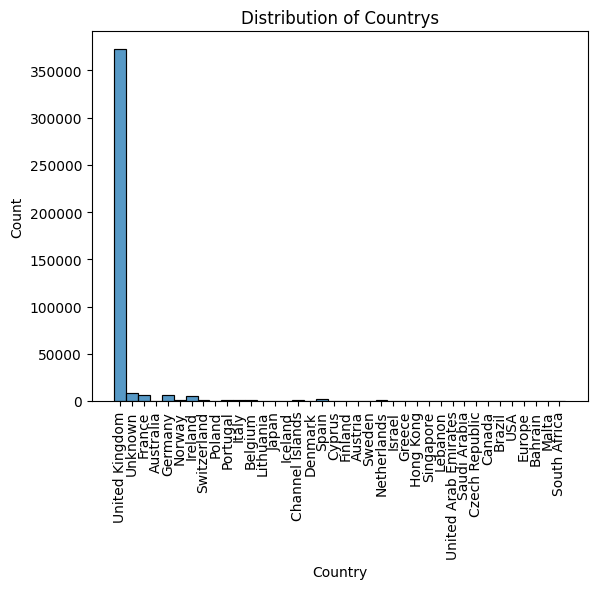

Quantity      1.498444
TotalPrice    3.875923
dtype: float64
Quantity       1.542986
TotalPrice    25.486058
dtype: float64
38
3775
Correlation between Recency and Monetary: -0.04903674768374391
            Recency  Frequency  Monetary
Recency    1.000000  -0.035595 -0.049037
Frequency -0.035595   1.000000  0.995562
Monetary  -0.049037   0.995562  1.000000


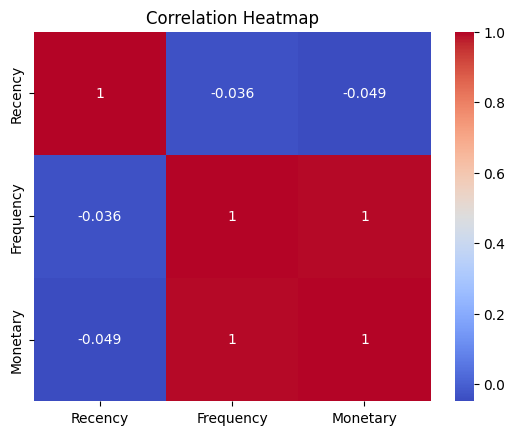

C:\Users\Admin\AppData\Local\Temp\ipykernel_20652\862265562.py:172: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Country', y='purchase_totals', data=purches_countrywise.sort_values('purchase_totals', ascending=False), palette='viridis')


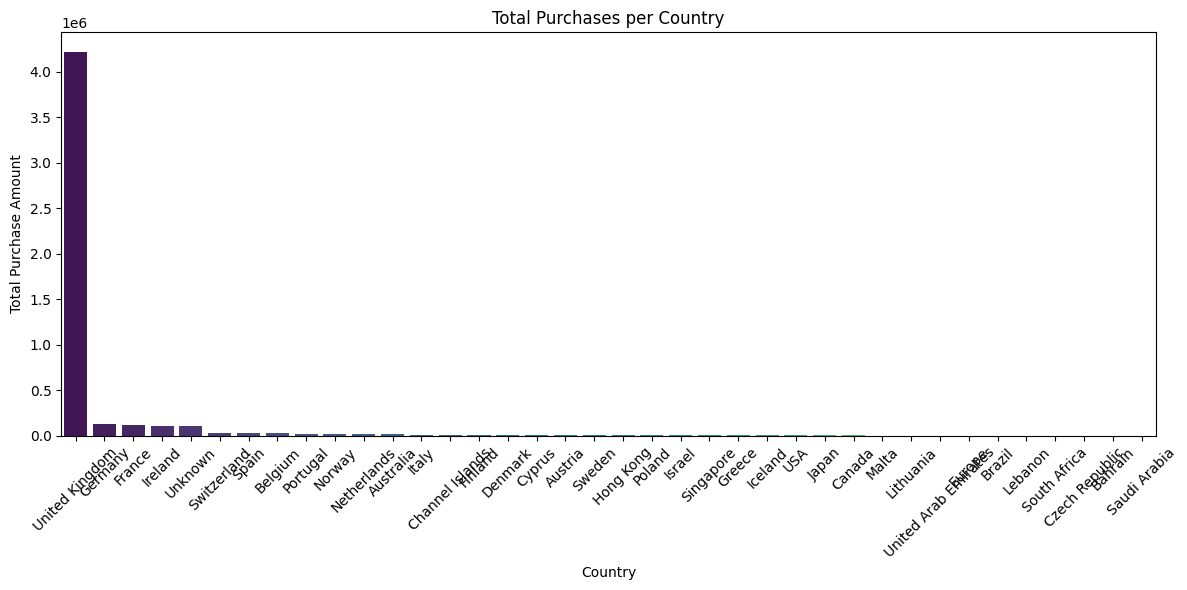

C:\Users\Admin\AppData\Local\Temp\ipykernel_20652\862265562.py:183: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Country', y='Unique_Customers', data=customers_per_country.sort_values('Unique_Customers', ascending=False), palette='coolwarm')


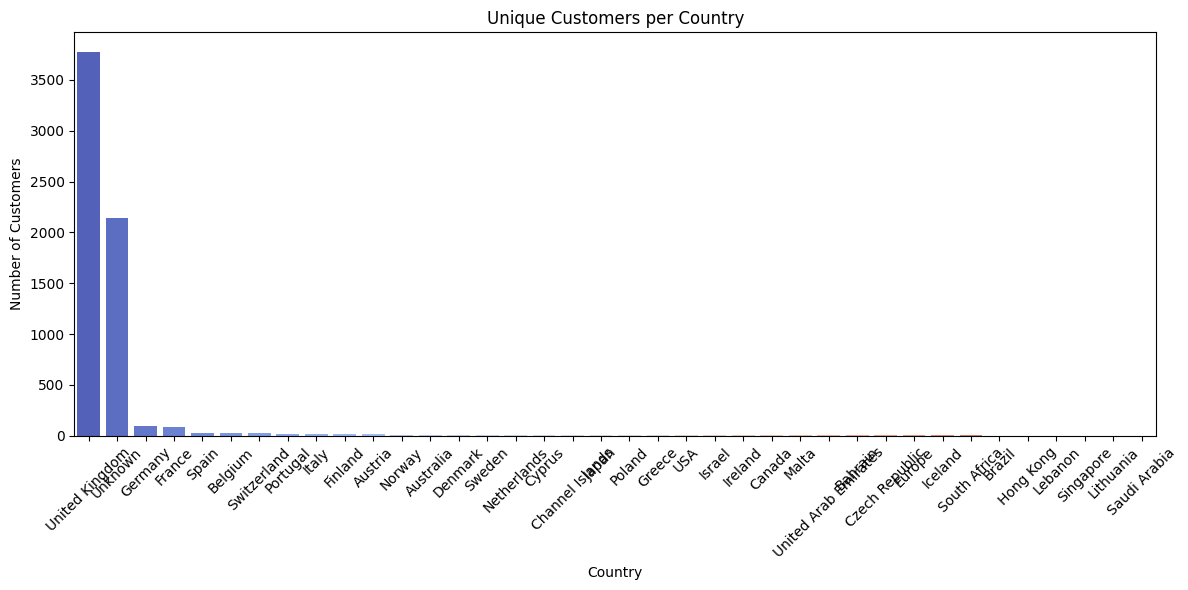

C:\Users\Admin\AppData\Local\Temp\ipykernel_20652\862265562.py:193: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Quantity', y='Description', data=top_items.head(10), palette='magma')


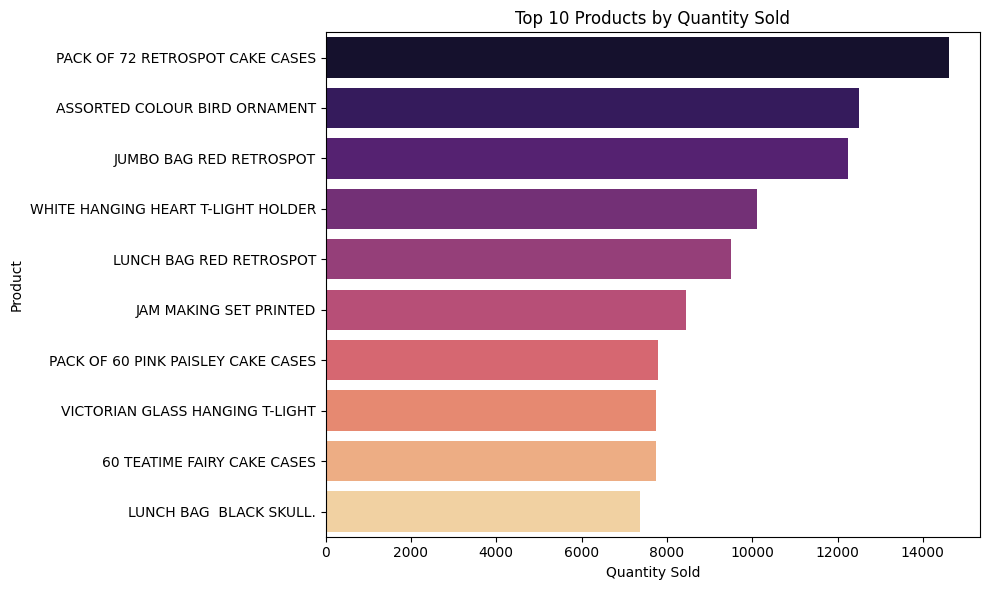

C:\Users\Admin\AppData\Local\Temp\ipykernel_20652\862265562.py:204: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TotalPrice', y='Description', data=top_products_revenue.head(10), palette='plasma')


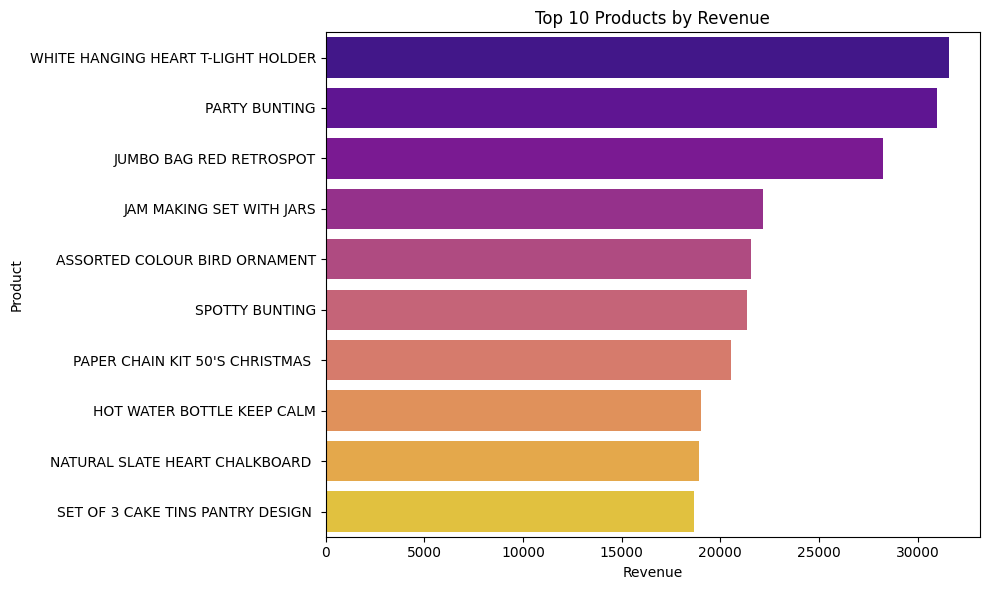

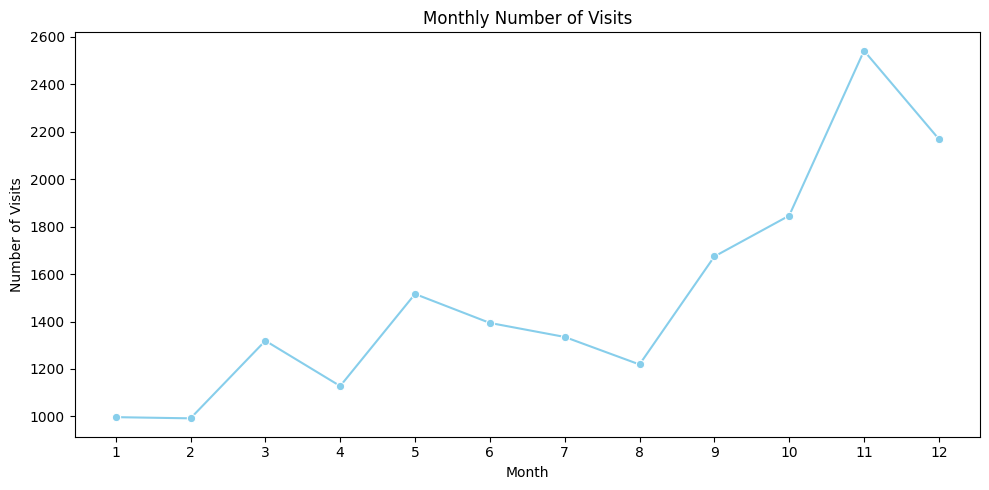

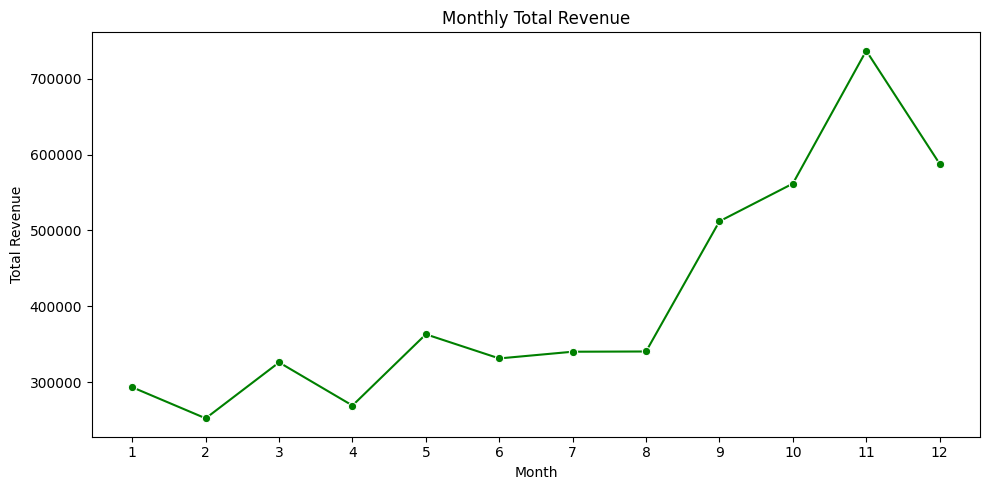

In [11]:
#----Week 3---------
# Week 3: Exploratory Data Analysis

# Member1: Ensure data quality for analysis(sanity checks)
# since cleaning and scaling already done checks done to confirm
# check for unexpected values in country column

unique_countries = df_clean['Country'].unique()
print(unique_countries)

# check for quantity < 0
qty_issues = data[data['Quantity'] <= 0]
print("Rows with Quantity ≤ 0: ", len(qty_issues))

# check for unit price < 0
up_issues = df_clean[df_clean['UnitPrice'] <= 0]
print("Rows with unit price ≤ 0: ", len(up_issues))

# Check for Duplicate InvoiceNo ( decided to ignore since multiple products can be bought at one time)
dup_inv_count = df_clean['InvoiceNo'].duplicated().sum()
print("Duplicate InvoiceNo: ", dup_inv_count)

# Check for Missing Product Descriptions
missing_prod_count = df_clean['Description'].isnull().sum()
print("Missing Product Descriptions: ", missing_prod_count)

# Check for Invalid or Missing Dates
inv_dates_count = df_clean[df_clean['InvoiceDate'].isnull()].shape[0]
print("Invalid or Missing Dates: ", inv_dates_count)

# Passed sanity check

# Member2: Create demographic and geographic analyses
# 1.) purchases per country
df_clean['Quantity'] = df_clean['Quantity'].fillna(0)
# create a new column purchase_totals that is the product of quantity and unitprice
purchase_totals =  df_clean['Quantity'] * df_clean['UnitPrice']
df_clean['purchase_totals'] = purchase_totals
# purchases per country
purches_countrywise = df_clean.groupby('Country')['purchase_totals'].sum().reset_index()
print('purchases per country')
print(purches_countrywise)

# 2.) Top item purchases
top_items = df_clean.groupby('Description')['Quantity'].sum().reset_index()
top_items = top_items.sort_values(by='Quantity', ascending=False)
print('Top item purchases')
print(top_items.head(10))

# 3.) Customer count per country
customers_per_country = df_clean.groupby('Country')['CustomerID'].nunique().reset_index()
customers_per_country.rename(columns={'CustomerID': 'Unique_Customers'}, inplace=True)

print(customers_per_country)

# 4.) Average purchases per visit
avg_purchase_per_visit = df_clean.groupby('InvoiceNo')['TotalPrice'].mean().reset_index()
avg_purchase_per_visit

# 5.) RFM-based customer segmentation( how much each customer bought when they last bought)
# Change invoice date to date time
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# change customer id to string
df_clean['CustomerID'] = df_clean['CustomerID'].astype(str)

# confirm datatypes before proceeding
df_clean.dtypes

# Separate colums to use
rmf_df = df_clean[['CustomerID', 'InvoiceDate', 'TotalPrice','InvoiceNo']].copy()

# Get most recent date from Invoice date
most_recent_date = rmf_df['InvoiceDate'].max()
print(most_recent_date)

today_date= pd.to_datetime('2012-01-01')

# Aggregate to customer-level RFM
rfm_df = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda v: (today_date - v.max()).days,  # Recency
    'InvoiceNo': 'count',                                  # Frequency
    'TotalPrice': 'sum'                                    # Monetary
}).reset_index()

# Rename columns
rfm_df.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

# RFM scoring
r = pd.qcut(rfm_df['Recency'], q=5, labels=[5,4,3,2,1])
f = pd.qcut(rfm_df['Frequency'], q=5, labels=[1,2,3,4,5], duplicates='drop')
m = pd.qcut(rfm_df['Monetary'], q=5, labels=[1,2,3,4,5], duplicates='drop')

# Add scores
rfm = rfm_df.assign(R=r.values, F=f.values, M=m.values)
print(rfm.head())

# Member3: Lead statistical analysis and correlation studies

# 1.)summary statistics
print(df_clean[['Quantity','TotalPrice']].describe())

# average purchases per country
avg_purchases_per_country = df_clean.groupby('Country')['TotalPrice'].mean().reset_index()
print('the top 10 highest averaging countries: \n')
avg_purchases_per_country.head(10)

# distributions
sns.histplot(df_clean['Country'])
plt.title('Distribution of Countrys')
plt.xticks(rotation=90)
plt.show()

# test for skewness and kurtosis
print(df_clean[['Quantity','TotalPrice']].skew())
print(df_clean[['Quantity','TotalPrice']].kurt())

# No. of unique vals in categorical columns
print(df_clean['Country'].nunique())
print(df_clean['Description'].nunique())


# correlation btn recency & monetary
correlation = rfm['Recency'].corr(rfm['Monetary'])
print(f"Correlation between Recency and Monetary: {correlation}")

corr_matrix = rfm_df[['Recency','Frequency','Monetary']].corr()
print(corr_matrix)

# Heatmap for visual understanding
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Member4: Prepare feature selection for mining phase
# describe goal
# Association rules needs- InvoiceNo, CustomerID, Description, Quantity.
# RFM clustering needs- Recency, Frequency, Monetary.
# Identify  available features:

# Numeric: Recency,Frequency,Monetary,Quantity,Totalprice
# Categorical: Country, Product Category(also encoded ), CustomerID , IsReturn(bool)

# Have the relevant features in 1 df

# make df for rfm Segmentation
df_rfm = rfm_df.copy()

# Make df for apriori

# df_apriori= encoded_products.copy()

# # encode the left non nominal data(country)
# df_features = pd.get_dummies(df_features, columns=['Country'], drop_first=True)
# df_features.head()

# # save features df
# df_features = r"/content/drive/MyDrive/DataMining_GroupProject_EcomAnalytics/data/raw/df_features.xlsx"
# data.to_excel(cleaned_path, index=False)
# print(f"\nCLEANING COMPLETE. File saved to: df_features")

# splitting won't be done now since apriori and RFM Segmentation don't require spliting

# Member5: Create EDA visualization portfolio

# Total purchases per country
plt.figure(figsize=(12,6))
sns.barplot(x='Country', y='purchase_totals', data=purches_countrywise.sort_values('purchase_totals', ascending=False), palette='viridis')
plt.title('Total Purchases per Country')
plt.xticks(rotation=45)
plt.ylabel('Total Purchase Amount')
plt.xlabel('Country')
plt.tight_layout()
plt.show()

# Unique customers per country

plt.figure(figsize=(12,6))
sns.barplot(x='Country', y='Unique_Customers', data=customers_per_country.sort_values('Unique_Customers', ascending=False), palette='coolwarm')
plt.title('Unique Customers per Country')
plt.xticks(rotation=45)
plt.ylabel('Number of Customers')
plt.xlabel('Country')
plt.tight_layout()
plt.show()

# Top 10 products by quantity
plt.figure(figsize=(10,6))
sns.barplot(x='Quantity', y='Description', data=top_items.head(10), palette='magma')
plt.title('Top 10 Products by Quantity Sold')
plt.xlabel('Quantity Sold')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

# Top 10 products by revenue

top_products_revenue = df_clean.groupby('Description')['TotalPrice'].sum().reset_index().sort_values('TotalPrice', ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x='TotalPrice', y='Description', data=top_products_revenue.head(10), palette='plasma')
plt.title('Top 10 Products by Revenue')
plt.xlabel('Revenue')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

# Monthly visits
# make a new df with month and count of invoices
monthly_visits = df_clean.groupby('Month')['InvoiceNo'].nunique().reset_index()
monthly_visits.rename(columns={'InvoiceNo': 'TotalVisits'}, inplace=True)

plt.figure(figsize=(10,5))
sns.lineplot(x='Month', y='TotalVisits', data=monthly_visits, marker='o', color='skyblue')
plt.title('Monthly Number of Visits')
plt.xlabel('Month')
plt.ylabel('Number of Visits')
plt.xticks(range(1,13))
plt.tight_layout()
plt.show()

# Total revenue over time

monthly_revenue = df_clean.groupby('Month')['TotalPrice'].sum().reset_index()
plt.figure(figsize=(10,5))
sns.lineplot(x='Month', y='TotalPrice', data=monthly_revenue, marker='o', color='green')
plt.title('Monthly Total Revenue')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.xticks(range(1,13))
plt.tight_layout()
plt.show()